# PHYS 7332 - Class xy: Network Sparsification

**Daniel Uriel Gonzalez Quezada**

In [38]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter

from scipy.stats import binom

## 1. Introduction

Since the advent of faster computers and the internet in the 1990s, the number of large network datasets has increased significatively. Thus, new techniques have been on demand for analyzing, visualizing, and simulating dynamical processes on such networks. However, much of the details contained in large networks are redundant and/or do not contribute with much information. This might hinder the process of extracting meaningful insights due to the overwhelming amount of information contained in large networks. Also, this can make any algorithm in a large network computationally infeasible. Therefore, extracting the structurally and/or statistically significant components of the network is an important task in the analysis of complex networks. This is known as the _network reduction problem_.

---

### 1.1. The network reduction problem

Given a network $G=(V,E)$, we say that a _network reduction_ of $G$ is any process in which we end up with a new network $G' = (V', E')$, with $|V'| < |V|$ and $|E'| < |E|$. In other words, we say $G'$ is a reduced network of $G$ if it has fewer nodes and/or edges than $G$ does. 

For practical applications, it is desired that $G'$ preserves the key topological and dynamical properties of the original network $G$. What it is meant by _key features_ depends on the purpose of the reduction. For instance, if our goal is to speed up the runtime of an epidemic model in a large network, we definitely want our results to be similar in our reduced network with respect to the original one. In this case, we might not care too much if the visualization of the reduced network does not resemble that of the original network. However, if our purposoe is to produce a good visualization of a big network, we can ignore the dynamics and focus on having a nice visualization. A nice picture of a network reduction is provided below [1].

<img src="images/network_reduction.png" alt="A" width="700">

-------


### 1.2. Network sparsification as an instance of the general network reduction problem.

There are different ways of reducing the size of a network. First, one can think of merging _similar_ nodes, for example, into a supernode. The same can be done with edges. This process is known as _network coarsening_, which is the analogous of zooming out the network. In a network coarsening, we must decide how to group nodes. For example, we could group them by communities as measured by modularity or a blockmodel method.

In this notebook, we will study _network sparsification_, also known as _backbone extraction_, a form of network reduction in which we mantain nodes intact $|V| = |V'|$ while removing some of the edges of the network $|E'| < |E|$. The key difference from network coarsening is that in sparsification we keep the same level of description of the network, while removing some of the redundant elements. In general, we are interested in weighted undirected networks, which can be defined using a matrix $W$, such that

$$
W_{ij}=
\begin{cases}
    w_{ij}, & \text{weighted link between nodes } i \text{ and } j, \\
    0, & \text{otherwise,}
\end{cases}
$$
where $w_{ij} \in \mathbb{R}$. Most of the backbone extraction methods just work for weighted networks

---

### 1.3. Why and when network backbone extraction is useful.

One key reason why backbone extraction is useful lies in its ability to enhance interpretability. Real-world networks, such as social or biological networks, often contain a high degree of redundancy. This redundancy can obscure meaningful patterns and hinder the ability to draw insights from the network. By extracting the backbone, we can focus on the most significant relationships or connections, thereby simplifying the network while retaining its structural essence. For example, in a weighted network, backbone extraction might retain only the strongest or most statistically significant edges, which often correspond to the most meaningful interactions.

Another major motivation is computational efficiency. Many algorithms in network science, such as those used for community detection, pathfinding, or dynamical simulations, scale poorly with network size. Backbone extraction can significantly reduce the computational burden by minimizing the number of edges while keeping the core topology intact. This is particularly useful in applications such as epidemic modeling or large-scale simulations, where processing the full network may be infeasible.

Backbone extraction is also essential in visualization. Large networks can be visually overwhelming, making it difficult to discern meaningful patterns. A well-extracted backbone, however, highlights key structures and relationships, producing cleaner and more interpretable visual representations. For instance, extracting the backbone of a transportation network might reveal the primary routes of connectivity between major hubs, offering insights into its efficiency or vulnerabilities.

---

### 1.4 The issue with real and complex networks

 Many real-world networks exhibit heavy-tailed degree distributions, where a small number of nodes, usually known as hubs, dominate the network in terms of connectivity, while most nodes have only a few connections. Such heterogeneity leads to unique challenges, as heavy-tailed distributions imply divergent statistics, i.e. second moment $\langle k^2 \rangle$ in the BA model, making statistical analysis prone to bias if not handled carefully. Therefore, whichever method we use to reduce a network, it must not favor any scale and therefore, must operate at a local scale rather than a global one.

Additionally, real-world networks are often noisy and incomplete. Measurement errors, missing data, and the dynamic nature of many networks mean that the observed structure may not accurately reflect the true underlying network. This poses a significant problem for any analysis method, as it is difficult to differentiate between meaningful features and artifacts of noise.

------------------------------------------

## 2. Methods for network sparsification

The main goal of backbone extraction is to identify the most significant parts of a network. When filtering edges, we must have a decision procedure to discriminate meaningful relationships between nodes from more redundant, or noisy-like. There is no general recipe for this, and in practice it depends on the problem we are interested in solving. In the literature, one can identify two main methods: structural and statistical backbone extraction.

### 2.1 Statistical backbone extraction

In a statistical backbone extraction, we keep edges that are statistically significant as compared to a null model. In general, null models are one of the cornerstones of network science, as they allow us to have a sense of which structures might be the result of randonmness and those that might be the result of an underlying dynamic of the system.
    
#### 2.1.2 Disparity filter algorithm implementation
    
The disparity filter method for backbone extraction was proposed by Serrano, Boguñá, and Vespignani [2]. It is one of the first network sparsification models that takes a local perspective rather than a global one.

Disparity filter's key idea is to remove edges whose weights are likely to happen under the null hypothesis and keep those that are unlikely. To develop a solid mathematical derivation, let's start by defininf some useful quantities. First, we define the strenght of node $i$ as
$$
  s_i = \sum_{j=1}^n w_{ij}.
$$

We then define the normalized weights for all edges connected to node $i$ as
$$
  p_{ij} = \frac{w_{ij}}{s_i}.
$$

The null model proposed by Serrano et al is to assume that the normalized weights are uniformely sampled accross $k_i$ edges. Since the normalized weights for all edges connecting to node $i$ satisfy $\sum_{j=1}^{k_i} p_{ij} = 1$, the null model is equivalent to randomly place $k_i-1$ points in the $[0,1]$ interval, thus dividing it into $k_i$ segments, where each lenght represents the normalized weight of each edge. This is a beta distribution, where the p.d.f. for the interval size is
$$
\rho(x) dx = (k-1)(1-x)^{k-2}dx
$$

#### 2.1.2 Mathematical "Your Turn!"

Let's build a more solid mathematical intuition before we implement the disparity filter algorithm. The term above represents the p.d.f of the normalized edge size under the _null hypothesis_, i.e. assuming it is random. In order to choice which edges are we keeping, we need to discard those that are _compatible_ with the null hypothesis. For this, we use $p$ value, the probability that, if the null hypothesis is true, one obtains a value for the variable under consideration larger than or equal to the observed one.

**Question 1.** What is the probability of observing a weight smaller than $p_{ij}$ under the null hypothesis? In other words, write an expression for the cumulative probability $P(x < p_{ij})$ in the form of an integral.

**Question 2.** Now, what is the probability of having a normalized edge weight greater or equal than $p_{ij}$? For this expression, solve the integral obtained in question 1.

**Question 3.** The previous expression should give us the significance level $\alpha_{ij}$ for each edge. Now, we need to impose a condition to reject the null hypothesis, in other words, to have a decision procedure to remove those edges with weights thare are unlikely the result of randonmness. How would you do such thing?

___

**Answers below, don't look unless at least you tried!**

___

**Answer for Question 1.** Since we have a p.d.f., we must integrate in order to get the cumulative probability. Such that,
$$
P(x < p_{ij}) = \int_0^{p_{ij}} \rho(x) \, dx = (k_i-1) \int_0^{p_{ij}} (1-x)^{k-2} \, dx.
$$

**Answer for Question 2.** Since $P(x < p_{ij}) + P(x \geq p_{ij}) = 1$, then
$$
P(x \geq p_{ij}) = 1 - (k_i-1) \int_0^{p_{ij}} (1-x)^{k_i-2} \, dx.
$$

Solving the integral,
$$
P(x \geq p_{ij}) = 1 - (1-p_{ij})^{k_i-1}.
$$

**Answer for Question 3.** The previous result is known as the significance level, which we call $\alpha_{ij}$. In order to keep those edges that are not compatible with the null hypothesis, i.e. that are very unlikely to be the result of randomness, we can simply impose a significance level restriction,
$$
a_{ij} = 1 - (1-p_{ij})^{k_i-1} < \alpha.
$$

Where $\alpha$ is an arbitrary significance level value.

#### 2.1.3 Your Turn!

Now that we have a solid mathematical intuition, implement a code to use disparity filter on a network! Keep in mind the steps covered so far:

1. Compute the normalized edge weights $p_{ij}$ for each node
2. Compute the significance level $\alpha_{ij}$ for each edge.
3. Keep only those edges that reject the null hypothesis, i.e. $\alpha_{ij} < \alpha$.

Test your code on any network of your preference for a few alpha values. Visualize both the original network and the sparsified ones in a single plot.

In [3]:
def disparity_filter(G, alpha):
    """
    Extract the backbone of a weighted network using the disparity filter method.

    Parameters
    ----------
    G : networkx.Graph
        A weighted graph where the weights represent the strength or importance of edges.
        The graph should have weights stored as edge attributes with the key 'weight'.
        
    alpha : float
        The significance level (0 < alpha < 1) used to determine which edges to retain.
        Smaller values of alpha result in a sparser backbone.

    Returns
    -------
    backbone : networkx.Graph
        A graph containing only the edges that pass the disparity filter at the given
        significance level. The structure and nodes of the input graph are preserved,
        but only a subset of edges remains.
    
    Notes
    -----
    The disparity filter identifies statistically significant edges by comparing the
    weight of an edge to a null model where weights are uniformly distributed among
    neighbors. This method preserves edges that are unlikely to have arisen by chance.
    """
    ##### Write your function here ######
    pass
    return backbone

___

**Answer below, don't look unless you tried!**

___

In [4]:
def disparity_filter(G, alpha, directed=False):
    """
    Extract the backbone of a weighted network using the disparity filter method.

    Parameters
    ----------
    G : networkx.Graph
        A weighted graph where the weights represent the strength or importance of edges.
        The graph should have weights stored as edge attributes with the key 'weight'.
        
    alpha : float
        The significance level (0 < alpha < 1) used to determine which edges to retain.
        Smaller values of alpha result in a sparser backbone.

    Returns
    -------
    backbone : networkx.Graph
        A graph containing only the edges that pass the disparity filter at the given
        significance level. The structure and nodes of the input graph are preserved,
        but only a subset of edges remains.
    
    Notes
    -----
    The disparity filter identifies statistically significant edges by comparing the
    weight of an edge to a null model where weights are uniformly distributed among
    neighbors. This method preserves edges that are unlikely to have arisen by chance.
    """
    if directed:
        backbone = nx.DiGraph()
    else:
        backbone = nx.Graph()
    for i in G:
        k_i = len(G[i]) # Degree of node i
        if k_i > 1: # This step is not strictly necessary, but since disparity filter will always remove edges connected to nodes with degree equal to one,
                    # we can directly skip such edges.
            # Sum of weights for all neighbors of node i, i.e. strenght of node i
            s_i = sum(G[i][j]['weight'] for j in G[i])
            for j in G[i]:
                p_ij = G[i][j]['weight'] / s_i
                # Check significance condition
                if (1 - p_ij) ** (k_i - 1) < alpha:
                    backbone.add_edge(i, j, weight=G[i][j]['weight'])
    return backbone

In [5]:
G = nx.karate_club_graph()
G.edges(data=True) # As we can see, the Karate Club graph is a weighted network

EdgeDataView([(0, 1, {'weight': 4}), (0, 2, {'weight': 5}), (0, 3, {'weight': 3}), (0, 4, {'weight': 3}), (0, 5, {'weight': 3}), (0, 6, {'weight': 3}), (0, 7, {'weight': 2}), (0, 8, {'weight': 2}), (0, 10, {'weight': 2}), (0, 11, {'weight': 3}), (0, 12, {'weight': 1}), (0, 13, {'weight': 3}), (0, 17, {'weight': 2}), (0, 19, {'weight': 2}), (0, 21, {'weight': 2}), (0, 31, {'weight': 2}), (1, 2, {'weight': 6}), (1, 3, {'weight': 3}), (1, 7, {'weight': 4}), (1, 13, {'weight': 5}), (1, 17, {'weight': 1}), (1, 19, {'weight': 2}), (1, 21, {'weight': 2}), (1, 30, {'weight': 2}), (2, 3, {'weight': 3}), (2, 7, {'weight': 4}), (2, 8, {'weight': 5}), (2, 9, {'weight': 1}), (2, 13, {'weight': 3}), (2, 27, {'weight': 2}), (2, 28, {'weight': 2}), (2, 32, {'weight': 2}), (3, 7, {'weight': 3}), (3, 12, {'weight': 3}), (3, 13, {'weight': 3}), (4, 6, {'weight': 2}), (4, 10, {'weight': 3}), (5, 6, {'weight': 5}), (5, 10, {'weight': 3}), (5, 16, {'weight': 3}), (6, 16, {'weight': 3}), (8, 30, {'weight': 3

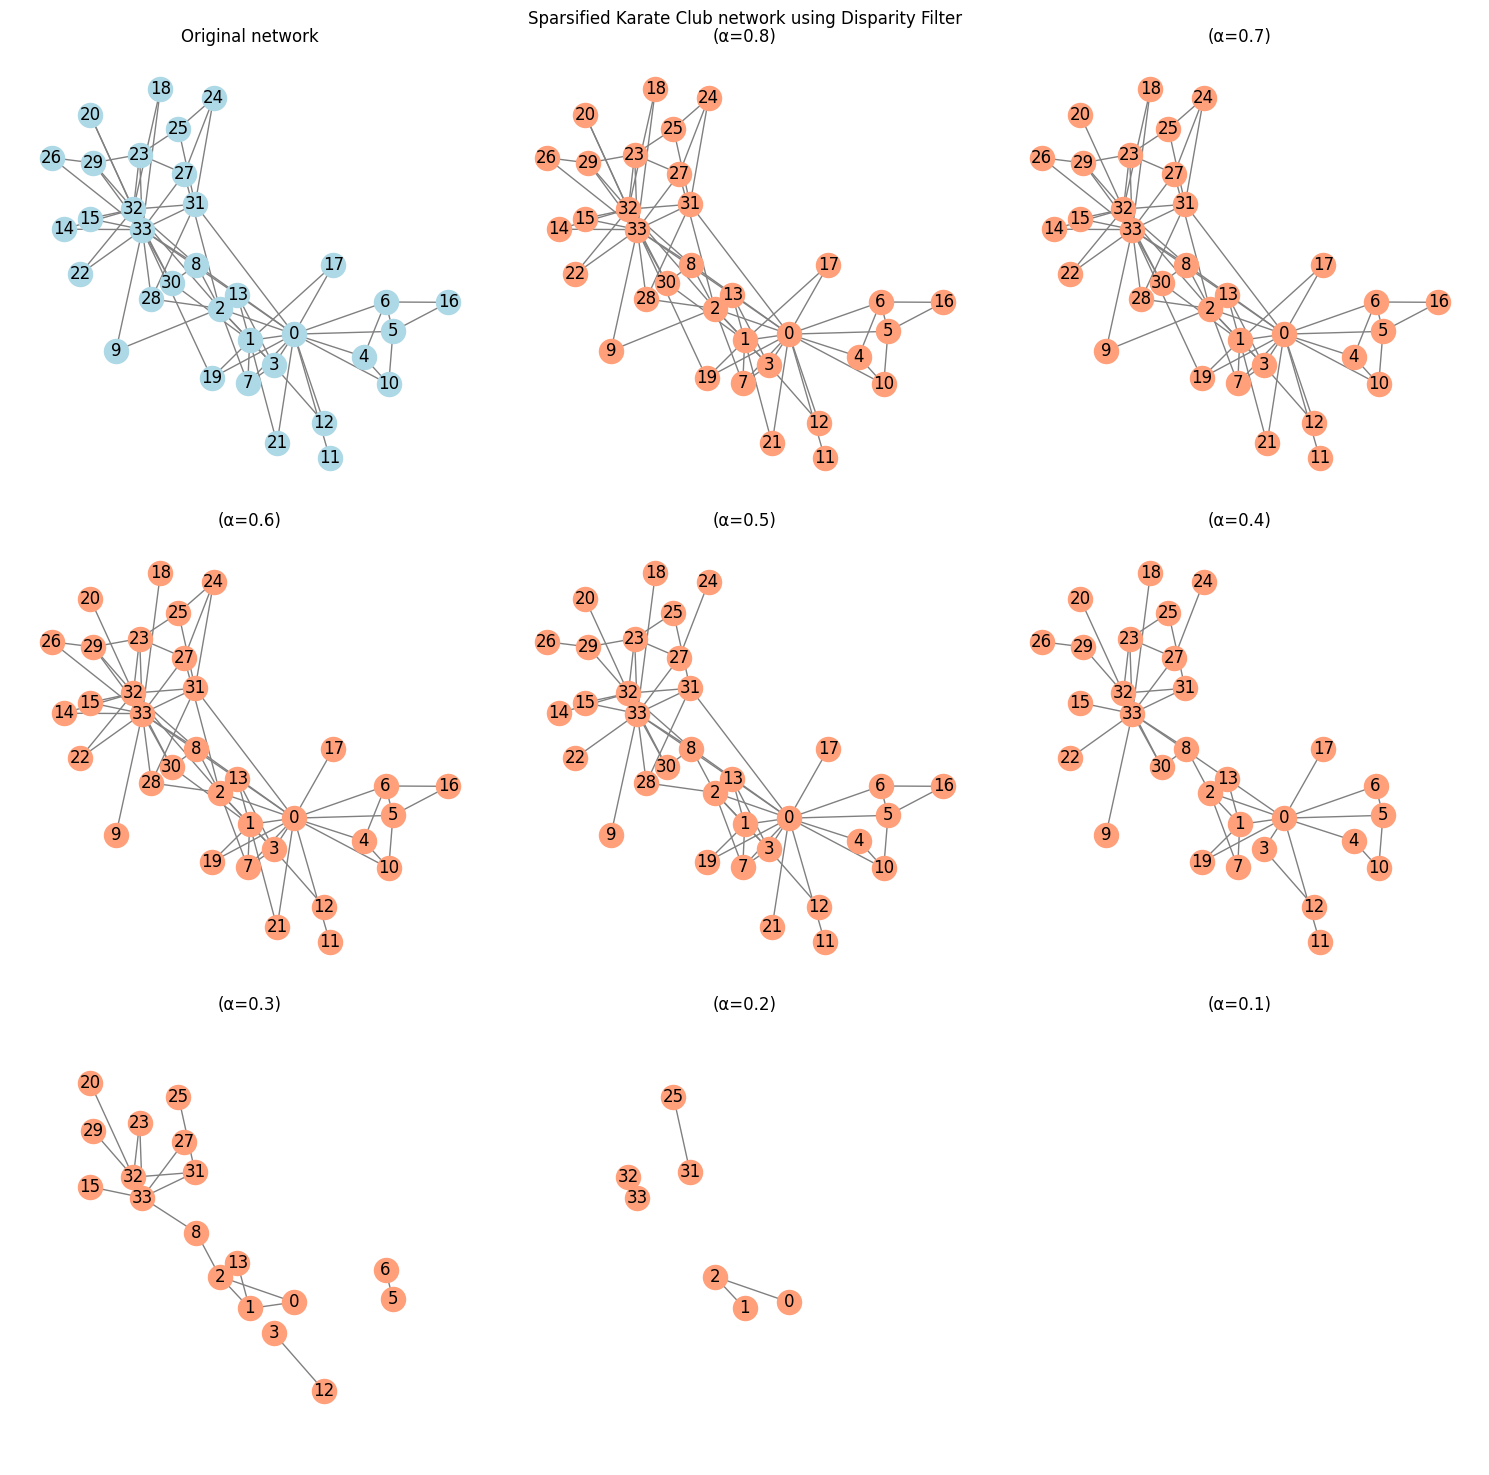

In [6]:
sparsified_graphs = {}
alphas = np.arange(0.1, 0.9, 0.1)

positions = nx.spring_layout(G, seed=3141592)

fig, axes = plt.subplots(3, 3, figsize=(15, 15), sharex=True, sharey=True) 

for i, alpha in enumerate(alphas):
    sparsified_graphs[alpha] = disparity_filter(G, alpha)
    
    nx.draw(
        sparsified_graphs[alpha], 
        pos=positions, 
        ax=axes.flat[-(i + 1)], 
        with_labels=True, 
        node_color="lightsalmon", 
        edge_color="gray"
    )
    axes.flat[-(i + 1)].set_title(f"(α={alpha:.1f})")

# Original network
nx.draw(
    G, 
    pos=positions, 
    ax=axes.flat[0], 
    with_labels=True, 
    node_color="lightblue", 
    edge_color="gray"
)
axes.flat[0].set_title("Original network")
plt.suptitle("Sparsified Karate Club network using Disparity Filter")
plt.tight_layout()
plt.show()

As we can observe, $\alpha = 0.4$ produces a very nice network with much less noise compared to the original one, while preserving the overall structure, i.e. a few hubs (nodes 0, 32, and 33). Before we move on further details, let's explore another way of performing backbone extraction.

#### 2.1.2 Advanced topic: Marginal Likelihood Filter

The Marginal Likelihood Filter, proposed by Dianati [3], is another statistical backbone extraction method designed to identify and retain the most significant edges in a weighted network. Unlike the Disparity Filter, which evaluates edge significance based on the perspective of individual nodes, the Marginal Likelihood Filter incorporates the combined contributions of both nodes connected by an edge. This provides a more nuanced framework for filtering edges based on their relevance in the network's structure.

##### Mathematical framework for the MLF

The Marginal Likelihood Filter treats each weighted edge in the network as the sum of multiple unit contributions. The null model assumes that these unit contributions are distributed randomly among all possible node pairs as in a configuration model, with probabilities proportional to the strengths of the two nodes involved. In other words, it follows a binomial distribution.

For an edge with weight $(i,j)$, the probability of observing at least $w_{ij}$ edge units under the null hypothesis is
$$
P(k \geq w_{ij}) = 1 - \sum_{k=0}^{w_{ij}}  \binom{N}{k} p_{ij}^k (1-p_{ij})^{N-k},
$$
where $p_{ij}=\frac{s_is_j}{\sum_{u,v}s_us_v}$ is the probability of assigning an edge under the null hypothesis. As we did with the Disparity Filter, we only keep those edges that are below a significance level $\alpha$, meaning that they are not compatible with the null model.

##### Implementation of the MLF

In [7]:
def marginal_likelihood_filter(G, alpha):
    """
    Extract the backbone of a weighted network using the Marginal Likelihood Filter.

    Parameters
    ----------
    G : networkx.Graph
        A weighted graph where edge weights represent the strength or importance of connections.
    alpha : float
        The significance level (0 < alpha < 1) used to determine which edges to retain.

    Returns
    -------
    backbone : networkx.Graph
        A graph containing only the edges that pass the Marginal Likelihood Filter at the given significance level.
    """
    backbone = nx.Graph()
    total_weight = sum(data['weight'] for _, _, data in G.edges(data=True))
    strengths = {node: sum(data['weight'] for _, _, data in G.edges(node, data=True)) for node in G}
    
    for u, v, data in G.edges(data=True):
        w_uv = data['weight']
        s_u, s_v = strengths[u], strengths[v]
        p = (s_u * s_v) / total_weight**2
        p_value = 1 - binom.cdf(w_uv - 1, total_weight, p)
        
        if p_value <= alpha:
            backbone.add_edge(u, v, weight=w_uv)
    
    return backbone

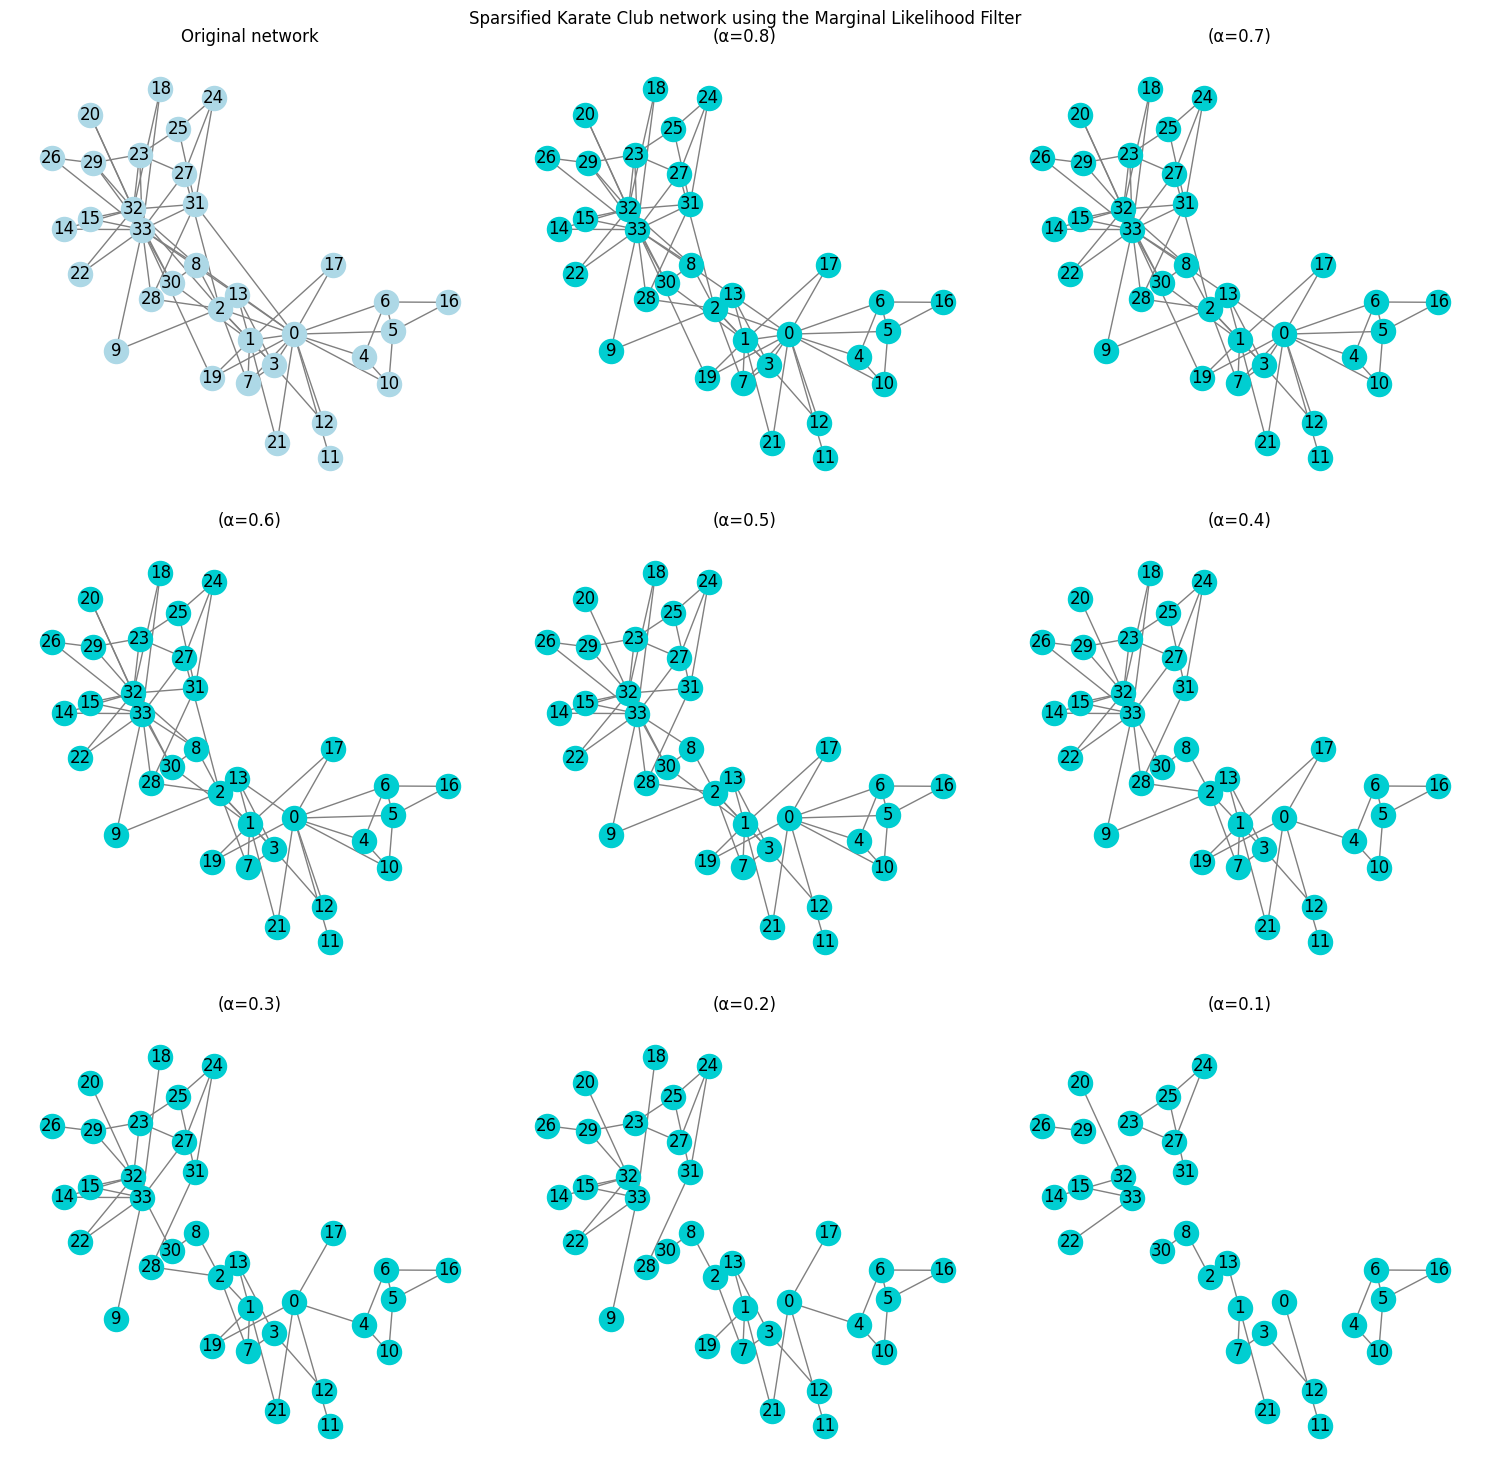

In [8]:
sparsified_graphs = {}
alphas = np.arange(0.1, 0.9, 0.1)

positions = nx.spring_layout(G, seed=3141592)

fig, axes = plt.subplots(3, 3, figsize=(15, 15), sharex=True, sharey=True) 

for i, alpha in enumerate(alphas):
    sparsified_graphs[alpha] = marginal_likelihood_filter(G, alpha)
    
    nx.draw(
        sparsified_graphs[alpha], 
        pos=positions, 
        ax=axes.flat[-(i + 1)], 
        with_labels=True, 
        node_color="darkturquoise", 
        edge_color="gray"
    )
    axes.flat[-(i + 1)].set_title(f"(α={alpha:.1f})")

# Original network
nx.draw(
    G, 
    pos=positions, 
    ax=axes.flat[0], 
    with_labels=True, 
    node_color="lightblue", 
    edge_color="gray"
)
axes.flat[0].set_title("Original network")
plt.suptitle("Sparsified Karate Club network using the Marginal Likelihood Filter")
plt.tight_layout()
plt.show()

### 2.2 Structural backbone extraction

Structural backbone methods operate on the network’s topology to extract a backbone with specific topological properties. One can divide them into two categories. The first category includes techniques for extracting a single substructure from the network. They cannot be adjusted and typically result in a single backbone. The second category assigns scores to nodes or edges based on topological features. Then, we keep those with scores above or below certain threshold [4].

#### 2.2.1 Global threshold

The simplest structural backbone extraction is to filter out edges whose weights are below certain threshold value. This is known as the global threhsold method. In other words, we only keep edges with weights $w_{ij} > \beta$. Let's implement this technique and do some experiments.

#### Your Turn!

Implement the global threshold method for a networkx graph.

In [9]:
def global_threshold(G, beta):
    """
    Extracts the backbone of a weighted graph using a global thresholding method.

    This function retains edges in the graph `G` whose weights are greater than or equal to 
    a specified threshold value `beta`. All other edges are removed, resulting in a subgraph 
    that represents the backbone structure of `G`.

    Parameters:
    -----------
    G : networkx.Graph
        A weighted graph where edges have an attribute 'weight' representing their strength.
    beta : float
        The threshold value. Edges with weights greater than or equal to `beta` are retained.

    Returns:
    --------
    backbone : networkx.Graph
        A subgraph of `G` containing only the edges that satisfy the weight threshold condition.
        The node set remains the same as in the original graph `G`.
    """
    # Write your code here
    pass
    return backbone

___

**Answer below, don't look unless you've tried!**

___

In [10]:
def global_threshold(G, beta):
    """
    Extracts the backbone of a weighted graph using a global thresholding method.

    This function retains edges in the graph `G` whose weights are greater than or equal to 
    a specified threshold value `beta`. All other edges are removed, resulting in a subgraph 
    that represents the backbone structure of `G`.

    Parameters:
    -----------
    G : networkx.Graph
        A weighted graph where edges have an attribute 'weight' representing their strength.
    beta : float
        The threshold value. Edges with weights greater than or equal to `beta` are retained.

    Returns:
    --------
    backbone : networkx.Graph
        A subgraph of `G` containing only the edges that satisfy the weight threshold condition.
        The node set remains the same as in the original graph `G`.
    """
    backbone = nx.Graph()
    backbone.add_edges_from([(i, j, edge_data) for i, j, edge_data in G.edges(data=True) if edge_data['weight'] >= beta])
    return backbone

Now, let's use global threshold on the Karate Club graph. First, let's quickly explore the edges distribution.

In [11]:
weight_counts = Counter([edge[2]["weight"] for edge in G.edges(data=True)])
weight_counts

Counter({3: 27, 2: 24, 4: 12, 5: 7, 1: 6, 6: 1, 7: 1})

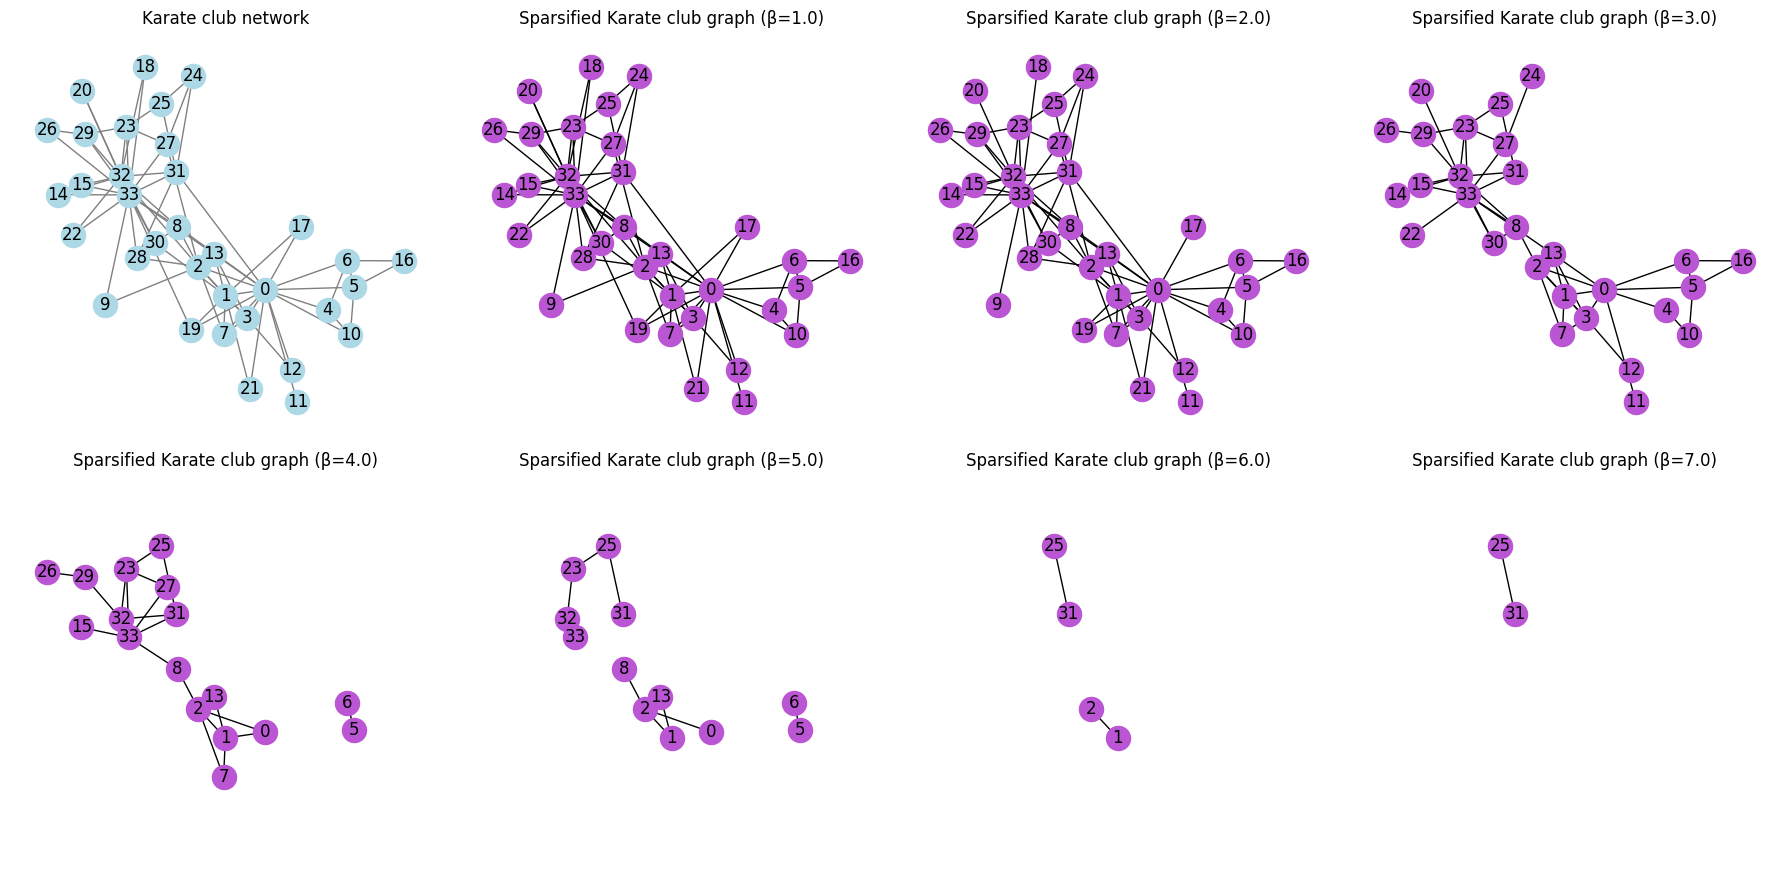

In [12]:
betas = range(1, 8)
sparsified_graphs_gt = {}
positions = nx.spring_layout(G, seed=3141592)

fig, axes = plt.subplots(2, 4, figsize=(18, 9), sharex=True, sharey=True) 


for i, beta in enumerate(betas):
    sparsified_graphs_gt[beta] = global_threshold(G, beta)
    
    nx.draw(
        sparsified_graphs_gt[beta], 
        pos=positions, 
        ax=axes.flat[(i + 1)], 
        with_labels=True, 
        node_color="mediumorchid", 
        edge_color="black"
    )
    axes.flat[(i + 1)].set_title(f"Sparsified Karate club graph (β={beta:.1f})")

# Original network
nx.draw(
    G, 
    pos=positions, 
    ax=axes.flat[0], 
    with_labels=True, 
    node_color="lightblue", 
    edge_color="gray"
)
axes.flat[0].set_title("Karate club network")

plt.tight_layout()
plt.show()

### 2.2.2 Maximum spanning trees

Another structural backbone extraction technique is the Maximum Spanning Tree (MST). A MST is a tree subgraph of a weighted network that connects all the nodes with the maximum possible total edge weight. This method ensures that the backbone will be a connected network. However, it erases almost all community structure.

One way of finding the MST is using Kruskal's algorithm. The steps are [5]:
1. Sort all edge weights.
2. Add the edge to the network. If it does not form a cycle, keep it. Otherwise, discard it.
3. Repeat step 2 until you have chosen $m-1$ edges. At this point we should have the MST.

We won't work through the implementation of this algorithm, as it is outside the scope of the notebook. Luckily, NetworkX has an implementation for this algorithm

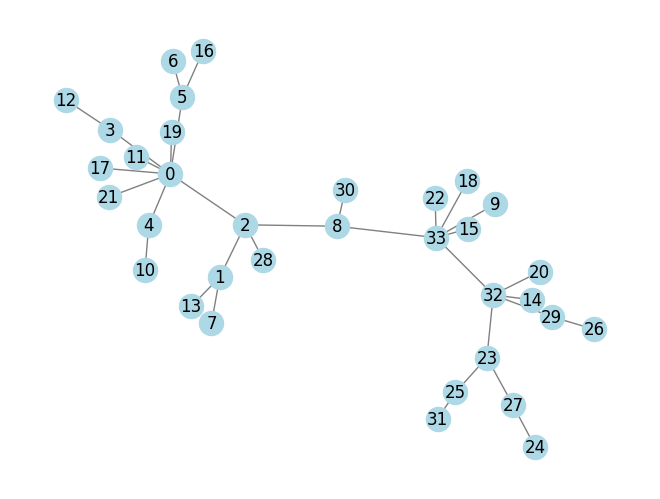

In [13]:
kc_mst = nx.maximum_spanning_tree(G, algorithm="kruskal")
nx.draw(
    kc_mst,
    with_labels=True, 
    node_color="lightblue", 
    edge_color="gray"
)
plt.show()

----

## 3. Evaluation techniques and applications

Evaluating the performance of backbone extraction methods is essential to ensure their reliability and appropriateness for specific tasks. Below, we will cover t a set of criteria and metrics that can be used to assess the performance of these methods. 

### 3.1 US domestic flights traffic data 2021-2022

In this section, we will use the domestic nonstop segment of the U.S. airport transportation system for the interval 2021-2022, which can be downloaded from [here](https://www.bts.gov/browse-statistical-products-and-data/bts-publications/data-bank-28ds-t-100-domestic-segment-data) [6].

In [14]:
df = pd.read_table("data/2021-2022 domestic flight data.asc", sep="|", low_memory=False)
df

,year,month,origin,origin_city_market_id,origin_wac,origin_city_name,dest,dest_city_market_id,dest_wac,dest_city_name,...,departures_scheduled,payload,seats,passengers,freight,mail,ramp_to_ramp,air_time,Wac,Unnamed: 28
0,2021,5,01A,30001,1,"Afognak Lake, AK",A43,30056,1,"Kodiak Island, AK",...,0,1200,6,1,0,0,20,18,1,NaN
1,2021,8,01A,30001,1,"Afognak Lake, AK",A43,30056,1,"Kodiak Island, AK",...,0,750,5,1,0,0,30,28,1,NaN
2,2022,8,01A,30001,1,"Afognak Lake, AK",A43,30056,1,"Kodiak Island, AK",...,0,2400,12,7,0,0,47,43,1,NaN
3,2021,8,01A,30001,1,"Afognak Lake, AK",A43,30056,1,"Kodiak Island, AK",...,0,2400,12,2,0,0,43,39,1,NaN
4,2021,9,01A,30001,1,"Afognak Lake, AK",A43,30056,1,"Kodiak Island, AK",...,0,6000,30,0,0,0,105,95,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
787386,2021,4,ZXU,36353,15,"North Kingstown, RI",TEB,35167,21,"Teterboro, NJ",...,0,3450,8,1,0,0,72,54,10,NaN
787387,2021,12,ZXU,36353,15,"North Kingstown, RI",TEB,35167,21,"Teterboro, NJ",...,0,3450,8,1,0,0,54,36,10,NaN
787388,2022,12,ZXU,36353,15,"North Kingstown, RI",TEB,35167,21,"Teterboro, NJ",...,0,3450,8,1,0,0,54,42,10,NaN
787389,2021,9,ZXU,36353,15,"North Kingstown, RI",TEB,35167,21,"Teterboro, NJ",...,0,3450,8,1,0,0,54,42,10,NaN


Let's do some quick exploration of the dataset

In [15]:
print("Number of unique origin airports", len(df["origin"].unique()))
print("Number of unique destination airports", len(df["dest"].unique()))
print()
print("Columns:", [column for column in df.columns])

Number of unique origin airports 1547
Number of unique destination airports 1544

Columns: ['year', 'month', 'origin', 'origin_city_market_id', 'origin_wac', 'origin_city_name', 'dest', 'dest_city_market_id', 'dest_wac', 'dest_city_name', 'Carrier', 'Carrier_Entity', 'carrier_group', 'distance', 'Svc_Class', 'Aircraft_Group', 'Aircraft_type', 'Aircraft_Config', 'departures_performed', 'departures_scheduled', 'payload', 'seats', 'passengers', 'freight', 'mail', 'ramp_to_ramp', 'air_time', 'Wac', 'Unnamed: 28']


In [16]:
df["route"] = df.apply(lambda row: tuple(sorted([row["origin"], row["dest"]])), axis=1)
edges = df.groupby("route")["passengers"].sum().reset_index()
edges[["airport_1", "airport_2"]] = pd.DataFrame(edges["route"].tolist(), index=edges.index)
edges = edges.drop(columns=["route"])
edges = edges.loc[edges["passengers"] > 0]
edges = edges.loc[edges["airport_1"] != edges["airport_2"]]
edges.sort_values(by="passengers", ascending=False)

,passengers,airport_1,airport_2
20617,4823868,JFK,LAX
3523,4774008,ATL,MCO
3458,4467829,ATL,FLL
21518,4326505,LAS,LAX
12428,4181994,DEN,PHX
...,...,...,...
2815,1,ANV,KWK
36,1,1B1,HYA
34,1,1B1,CTH
11695,1,CYS,TVL


Now, in order to produce some nice visualizations, nothing better than use the real coordinates of each airport. However, this is contained on a separate dataset, can also be downloaded [here](https://www.transtats.bts.gov/DL_SelectFields.aspx?gnoyr_VQ=FLL&QO_fu146_anzr=) [7].

In [17]:
unique_airports = pd.concat([edges["airport_1"], edges["airport_2"]]).unique()
print("Number of unique airports", len(unique_airports))
airport_coords = pd.read_csv("data/airport_coords.csv")
airport_coords = airport_coords[airport_coords["AIRPORT"].isin(unique_airports)].drop_duplicates(subset="AIRPORT", keep="first")
airport_coords

Number of unique airports 1501


,AIRPORT,DISPLAY_AIRPORT_CITY_NAME_FULL,LAT_DEGREES,LATITUDE,LON_DEGREES,LONGITUDE
0,01A,"Afognak Lake, AK",58.0,58.109444,152.0,-152.906667
3,05A,"Little Squaw, AK",67.0,67.570000,148.0,-148.183889
4,06A,"Kizhuyak, AK",57.0,57.745278,152.0,-152.882778
7,09A,"Homer, AK",59.0,59.362778,153.0,-153.430556
8,1AK,"Mertarvik, AK",60.0,60.818333,164.0,-164.518889
...,...,...,...,...,...,...
19156,ZXB,"Albuquerque, NM",35.0,35.145000,106.0,-106.795278
19167,ZXF,"Illinois Creek, AK",64.0,64.116667,157.0,-157.350000
19168,ZXH,"Chomondely Sound, AK",55.0,55.239167,132.0,-132.114167
19183,ZXU,"North Kingstown, RI",41.0,41.597222,71.0,-71.412222


We can now build our NetworkX graph.

In [18]:
airport_network = nx.Graph()
for _, row in edges.iterrows():
    airport_network.add_edge(row['airport_1'], row['airport_2'], weight=row['passengers'])
airport_network.remove_node("DQG") # No coordinates for this airport

In [19]:
airport_network = nx.Graph()
for _, row in edges.iterrows():
    airport_network.add_edge(row['airport_1'], row['airport_2'], weight=row['passengers'])
airport_network.remove_node("DQG") # No coordinates for this airport

print("Number of nodes", len(airport_network))
print("Number of edges", len(airport_network.edges))

Number of nodes 1500
Number of edges 20598


In [20]:
pos  = airport_coords.set_index('AIRPORT')[['LONGITUDE', 'LATITUDE']].apply(tuple, axis=1).to_dict()

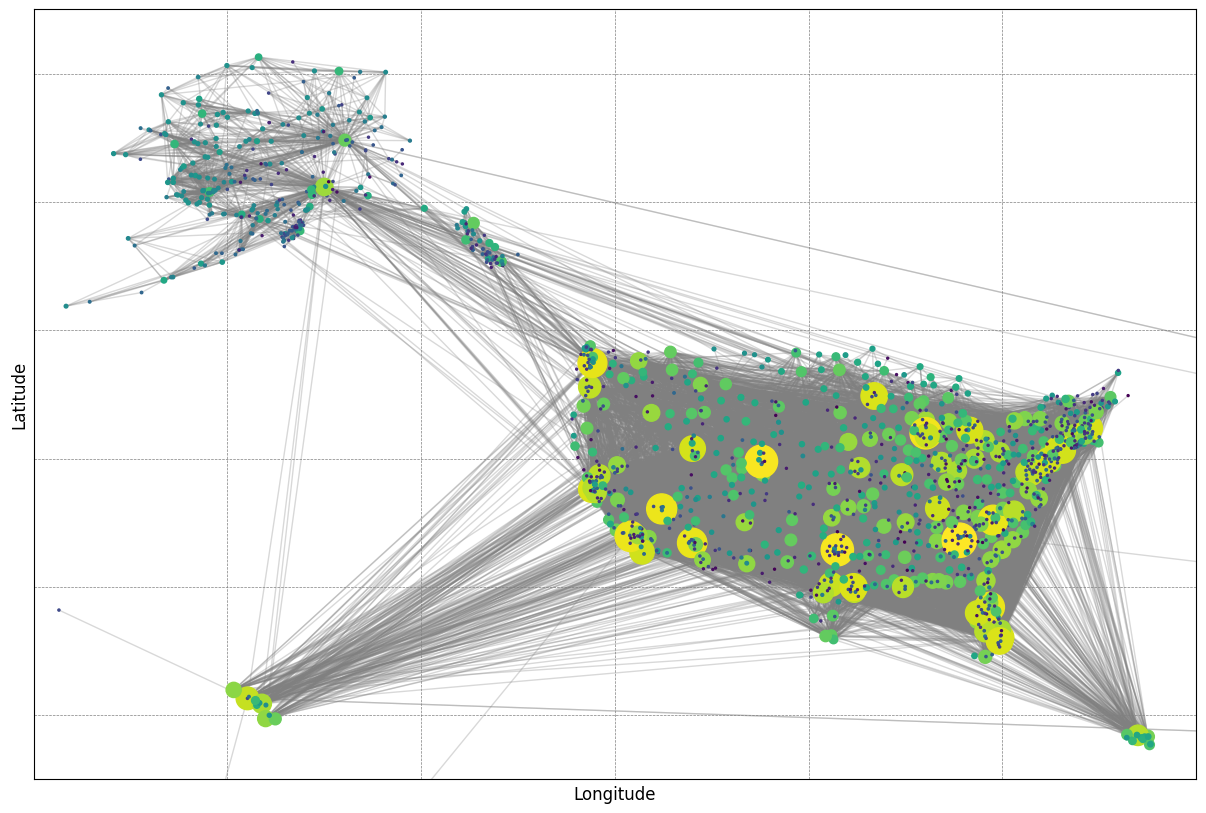

In [21]:
plt.figure(figsize=(15, 10))

plt.xlim(-180, -60) 
plt.ylim(15, 75) 

node_strength = {node: sum(weight for _, _, weight in airport_network.edges(node, data="weight")) for node in airport_network.nodes}
node_sizes = [2 + 0.05 * np.sqrt(node_strength[node]) for node in airport_network.nodes]
node_colors = [np.log10(node_strength[node]) for node in airport_network.nodes]

edge_weights = [np.log10(airport_network[u][v]["weight"]) for u, v in airport_network.edges]

nx.draw_networkx_nodes(airport_network, 
        pos=pos,
        node_color=node_colors,
        node_size=node_sizes,
        cmap=plt.cm.viridis
       )

nx.draw_networkx_edges(airport_network,
        pos=pos,
        alpha=0.3,
        edge_color="gray"
        )

plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.xlabel("Longitude", fontsize=12)
plt.ylabel("Latitude", fontsize=12)

plt.show()

As we can see, the visualization is not very informative. We can observer some hubs, but it is not possible to observer any useful details. Now, let's try with a sparsified version.

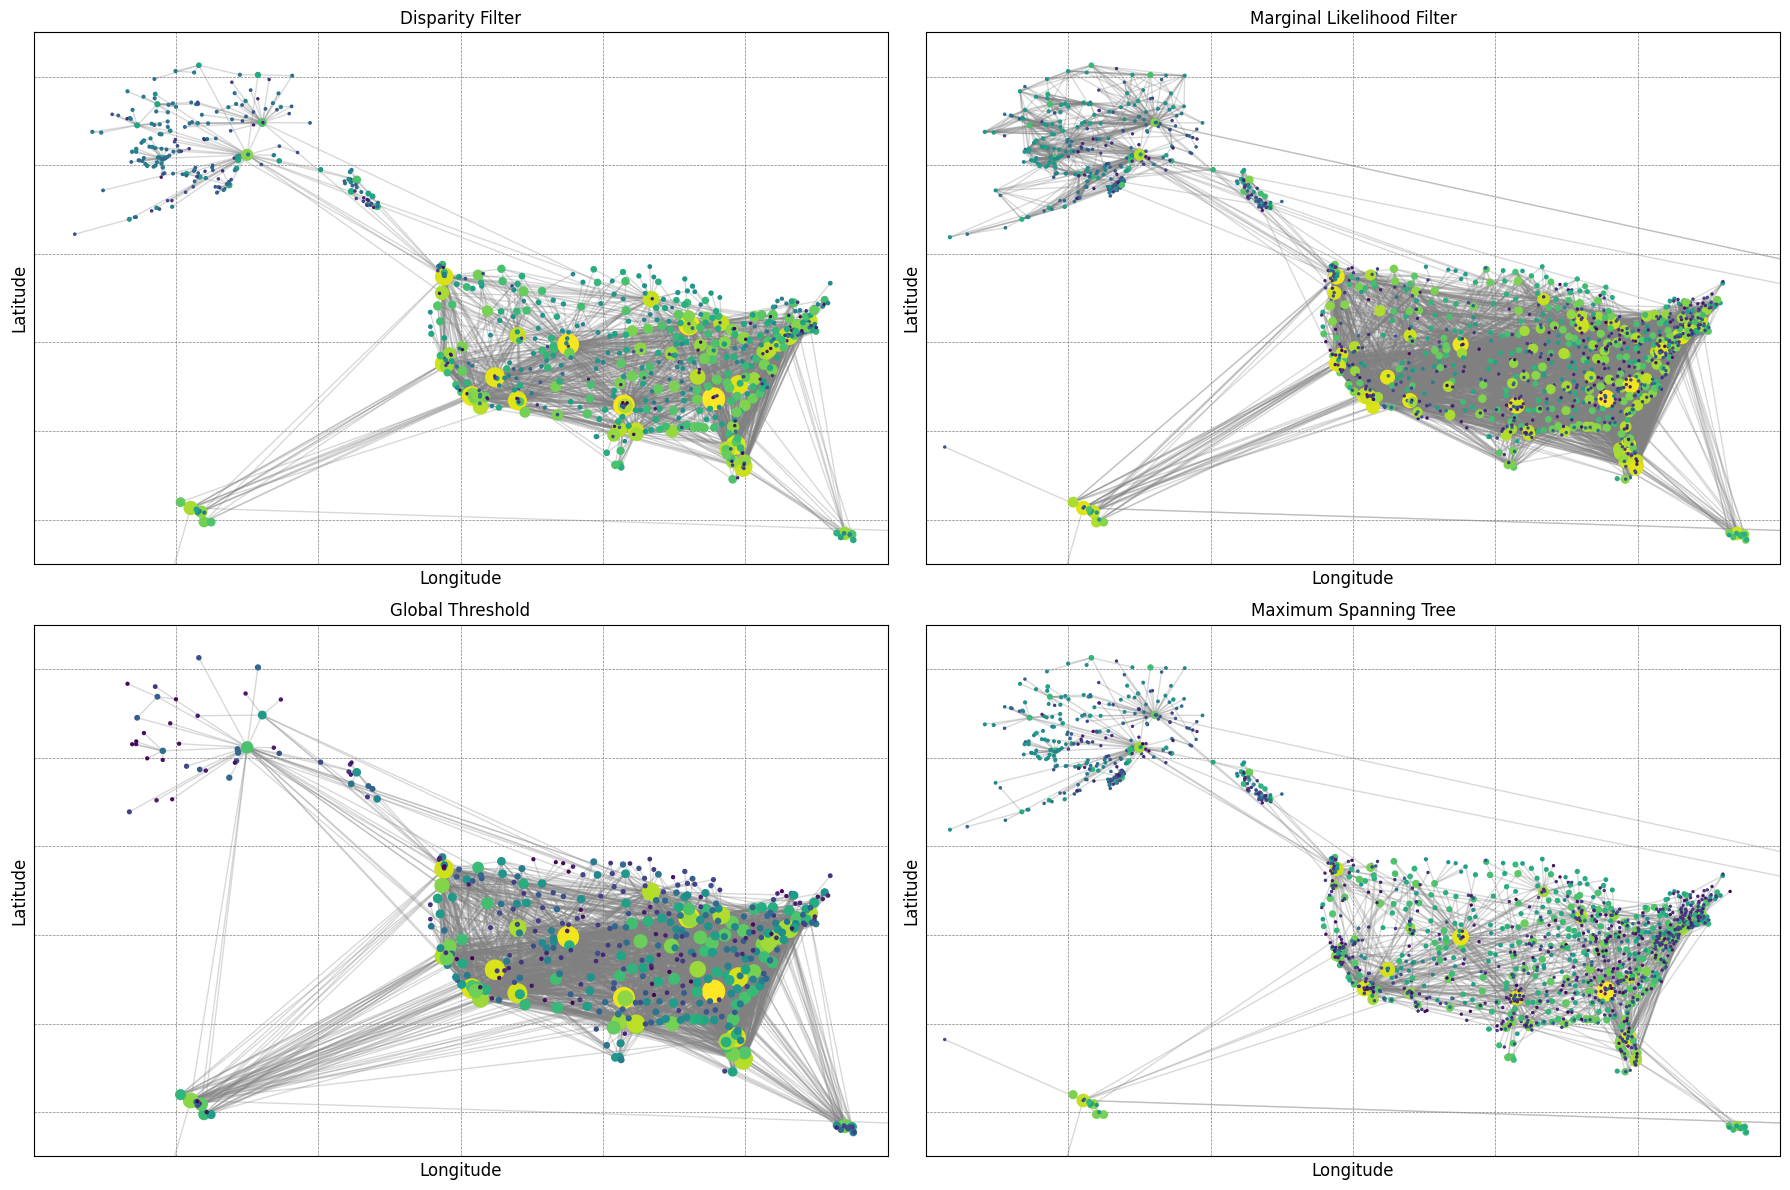

In [26]:
fig, axes = plt.subplots(2,2, figsize=(18,12), sharex=True, sharey=True)

plt.xlim(-180, -60) 
plt.ylim(15, 75)

func_names = ["Disparity Filter", "Marginal Likelihood Filter", "Global Threshold", "Maximum Spanning Tree"]
backbone_functions = [disparity_filter, marginal_likelihood_filter, global_threshold, nx.maximum_spanning_tree]
parameters = [0.01, 0.00001, 10000]
sparsified_networks = []

for i, func in enumerate(backbone_functions):
    if i < 3:
        airport_network_sparsified = func(airport_network, parameters[i])
    else:
        airport_network_sparsified = func(airport_network)
    sparsified_networks.append(airport_network_sparsified)
    node_strength = {node: sum(weight for _, _, weight in airport_network_sparsified.edges(node, data="weight")) for node in airport_network_sparsified.nodes}
    node_sizes = [2 + 0.02 * np.sqrt(node_strength[node]) for node in airport_network_sparsified.nodes]
    node_colors = [np.log10(node_strength[node]) for node in airport_network_sparsified.nodes]
    axes.flat[i].set_xlim(-180, -60)
    axes.flat[i].set_ylim(15, 75)
    nx.draw_networkx_nodes(airport_network_sparsified, 
            pos=pos,
            ax=axes.flat[i],
            node_color=node_colors,
            node_size=node_sizes,
            cmap=plt.cm.viridis
           )
    
    nx.draw_networkx_edges(airport_network_sparsified,
            pos=pos,
            ax=axes.flat[i],
            alpha=0.3,
            edge_color="gray"
            )
    axes.flat[i].grid(color='gray', linestyle='--', linewidth=0.5)
    axes.flat[i].set_xlabel("Longitude", fontsize=12)
    axes.flat[i].set_ylabel("Latitude", fontsize=12)
    axes.flat[i].set_title(func_names[i])
plt.tight_layout()
plt.show()


### 3.2 How to evaluate different backbone techniques?

So far, we have extracted different backbones for the U.S. domestic flights from 2021 to 2022. How can we evaluate the quality of each backbone? First, what we mean by quality will depend on our interests. For example, if we just care about having a nice visualization, we could that the backbones extracted using Disparity Filter and Maximum Spanning Tree are better than the other two. If we care about having connectivity, we could assert that MST is the best one. There are different things we could use as an evaluation metric to compare different backbones of a single network.

We can separate metrics intro three groups, where we measure: topological properties, topological properties distributions, and dynamics. In this notebook, we will mainly focus on topological properties.

#### 3.2.1 Topological properties

The simplest way of evaluating a backbone is by comparing different topological properties. Here, we select _node fraction_, _edge fraction_, _weight fraction_, _average degree, _density_, and _reachability_.

**Your Turn!**

Implement a function that computes the topological properties mentioned above for a list of backbones, and create a nice visualization of it.

In [30]:
def topological_properties(graph, original_graph):
    """
    Compute topological properties of a graph compared to the original graph.

    Parameters:
        graph (networkx.Graph): The backbone graph to evaluate.
        original_graph (networkx.Graph): The original graph to compare against.

    Returns:
        dict: A dictionary containing the following metrics:
            - Node Fraction: Fraction of nodes retained in the backbone.
            - Edge Fraction: Fraction of edges retained in the backbone.
            - Weight Fraction: Fraction of total edge weight retained in the backbone.
            - Average Degree: Average degree of nodes in the backbone.
            - Density: Density of the backbone.
            - Reachability: Fraction of nodes in the largest connected component.
    """
    ### Your code here
    return metrics

---

**Answer below, don't look unless you've tried!**

___

In [40]:
def topological_properties(graphs, original_graph):
    """
    Compute topological properties for a list of graphs compared to the original graph.

    Parameters:
        graphs (list of networkx.Graph): List of backbone graphs to evaluate.
        original_graph (networkx.Graph): The original graph to compare against.

    Returns:
        list of dict: A list of dictionaries containing the following metrics for each graph:
            - Node Fraction: Fraction of nodes retained in the backbone.
            - Edge Fraction: Fraction of edges retained in the backbone.
            - Weight Fraction: Fraction of total edge weight retained in the backbone.
            - Average Degree: Average degree of nodes in the backbone.
            - Density: Density of the backbone.
            - Reachability: Fraction of nodes in the largest connected component.
    """
    metrics_list = []
    for graph in graphs:
        metrics = {}
        metrics["Node Fraction"] = graph.number_of_nodes() / original_graph.number_of_nodes()
        metrics["Edge Fraction"] = graph.number_of_edges() / original_graph.number_of_edges()
        total_weight_original = sum(weight for _, _, weight in original_graph.edges(data="weight", default=1))
        total_weight_backbone = sum(weight for _, _, weight in graph.edges(data="weight", default=1))
        metrics["Weight Fraction"] = total_weight_backbone / total_weight_original
        #metrics["Average Degree"] = np.mean([deg for _, deg in graph.degree()])
        metrics["Density"] = nx.density(graph)
        largest_cc = max(nx.connected_components(graph), key=len)
        metrics["Reachability"] = len(largest_cc) / graph.number_of_nodes()
        metrics_list.append(metrics)
    return metrics_list

In [35]:
def radar_chart(metrics_list, labels, title):
    """
    Create an improved radar chart to visualize multiple metrics across different backbones.

    Parameters:
        metrics_list (list of dict): List of dictionaries containing metrics for each backbone.
        labels (list of str): Labels for each backbone.
        title (str): Title of the radar chart.

    Returns:
        None
    """
    categories = list(metrics_list[0].keys())
    num_vars = len(categories)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"polar": True})
    for metrics, label in zip(metrics_list, labels):
        values = list(metrics.values())
        values += values[:1]
        ax.plot(angles, values, label=label, linewidth=2)
        ax.fill(angles, values, alpha=0.25)
    ax.set_yticks([0.25, 0.5, 0.75, 1.0])
    ax.set_yticklabels(["0.25", "0.5", "0.75", "1.0"], color="gray", size=8)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=10)
    ax.set_title(title, size=15, y=1.1)
    ax.grid(color="gray", linestyle="--", linewidth=0.5, alpha=0.7)
    ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1), fontsize=9)
    sns.set_style("whitegrid")
    plt.tight_layout()
    plt.show()

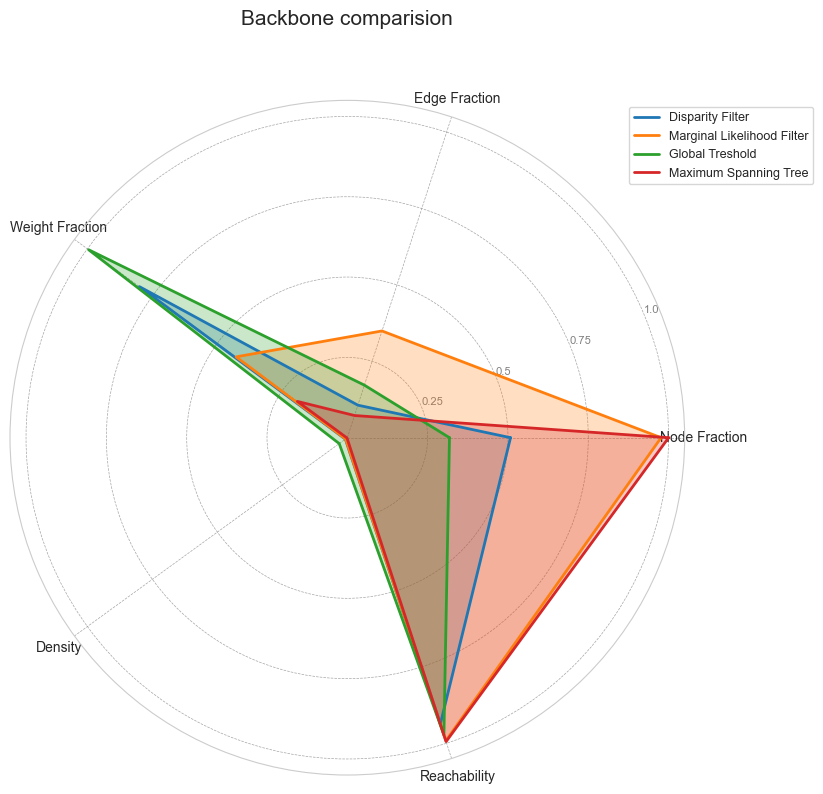

In [43]:
metrics_list = topological_properties(sparsified_networks, airport_network)
labels = ["Disparity Filter", "Marginal Likelihood Filter", "Global Treshold", "Maximum Spanning Tree"]
radar_chart(metrics_list, labels, "Backbone comparision")

However, we might also be interested in measuring the performance of a single or multiple backbone extractions for different parameter values. In other words, we might be interested in the behavior of the sparsification method.

#### 3.2.2 Edge fraction vs Node fraction

An interesting relationship studied and found in the network sparsification literature is that of edges and nodes fractions. For this, we are interested in plotting how these two quantities change as we change the significance level in statistical methods, or the threshold value for structural methods.

Let's write a simple function to do this.

**Your Turn!**

Write a function that takes a network, a backbone extraction method, and a set of parameter values, and produces a plot of the relation between edges fraction (horizontal axis) and nodes fractions (y axis).

In [52]:
def edge_node_relation_plot(graph, backbone_method, param_values):
    """
    Plot the relation between edge fraction and node fraction for a given network and backbone method.

    Parameters:
        graph (networkx.Graph): The original network.
        backbone_method (callable): A function that extracts the backbone from the network.
        param_values (list): A list of parameter values for the backbone method.

    Returns:
        None
    """
    edge_fractions = []
    node_fractions = []

    for param in param_values:
        backbone = backbone_method(graph, param)
        edge_fraction = backbone.number_of_edges() / graph.number_of_edges()
        node_fraction = backbone.number_of_nodes() / graph.number_of_nodes()
        edge_fractions.append(edge_fraction)
        node_fractions.append(node_fraction)

    return edge_fractions, node_fractions

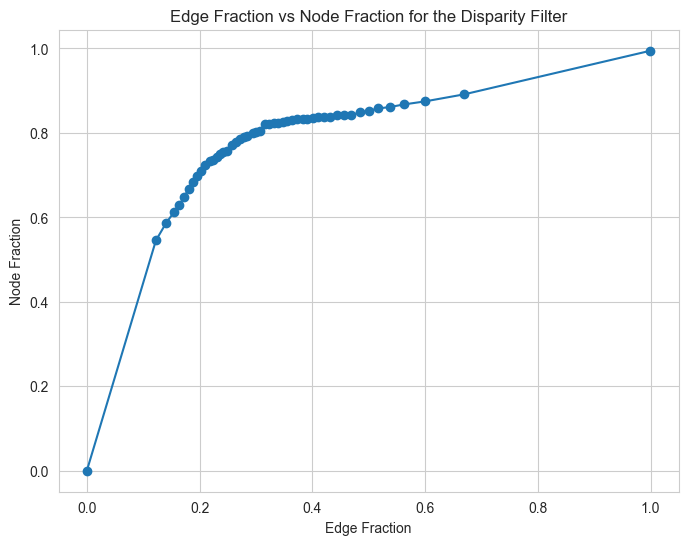

In [53]:
edge_fraction, node_fraction = edge_node_relation_plot(airport_network, disparity_filter, np.linspace(0, 1, 50))
plt.figure(figsize=(8, 6))
plt.plot(edge_fraction, node_fraction, marker="o")
plt.xlabel("Edge Fraction")
plt.ylabel("Node Fraction")
plt.title("Edge Fraction vs Node Fraction for the Disparity Filter")
plt.grid(True)
plt.show()

---

---

---

## References (so far)

[1] Hashemi, M., Gong, S., Ni, J., Fan, W., Prakash, B. A., & Jin, W. (2024). A Comprehensive Survey on Graph Reduction: Sparsification, Coarsening, and Condensation. arXiv. https://doi.org/10.24963/ijcai.2024/891

[2] Serrano, M. Á., Boguñá, M., & Vespignani, A. (2009). Extracting the multiscale backbone of complex weighted networks. Proceedings of the National Academy of Sciences, 106(16), 6483–6488. https://doi.org/10.1073/pnas.0808904106

[3] Dianati, N. (2016). Unwinding the hairball graph: Pruning algorithms for weighted complex networks. Physical Review E, 93(1), 012304. https://doi.org/10.1103/PhysRevE.93.012304.

[4] Yassin, A., Haidar, A., Cherifi, H., Seba, H., & Togni, O. (2023). An evaluation tool for backbone extraction techniques in weighted complex networks. Scientific Reports, 13(1). https://doi.org/10.1038/s41598-023-42076-3

[5] GeeksforGeeks. (n.d.). Kruskal's Minimum Spanning Tree Algorithm (Greedy Algo-2). GeeksforGeeks. https://www.geeksforgeeks.org/kruskals-minimum-spanning-tree-algorithm-greedy-algo-2/

[6] Bureau of Transportation Statistics. (n.d.). Data Bank 28: T-100 Domestic Segment Data. U.S. Department of Transportation. https://www.bts.gov/browse-statistical-products-and-data/bts-publications/data-bank-28ds-t-100-domestic-segment-data

[7] Bureau of Transportation Statistics. (n.d.). Transtats: Flight Data. U.S. Department of Transportation. https://www.transtats.bts.gov/DL_SelectFields.aspx?gnoyr_VQ=FLL&QO_fu146_anzr=

---